In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

uditbajpai_vehicle_data_path = kagglehub.dataset_download('uditbajpai/vehicle-data')
uditbajpai_classes_path = kagglehub.dataset_download('uditbajpai/classes')

print('Data source import complete.')


In [ ]:
import os
import shutil
import random
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define paths
data_dir = "../input/vehicle-data/data"
output_dir = "split_data/"
train_dir = os.path.join(output_dir, "train/")
val_dir = os.path.join(output_dir, "val/")

In [ ]:
# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

In [ ]:
# Remove existing directories if they exist
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create train, val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
# Loop through each class folder
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)
        train_idx = int(len(images) * train_ratio)

        train_images = images[:train_idx]
        val_images = images[train_idx:]

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Data split completed successfully!")

In [ ]:
# Define function to load and preprocess images
def load_and_process_images(data_path, img_npy, lbl_npy, img_width=180, img_height=180):
    if os.path.exists(img_npy) and os.path.exists(lbl_npy):
        images = np.load(img_npy)
        labels = np.load(lbl_npy)
    else:
        images, labels = [], []
        class_folders = sorted(glob.glob(os.path.join(data_path, "*")))
        print("Class folders:", class_folders)
        for class_idx, class_folder in enumerate(class_folders):
            image_paths = glob.glob(os.path.join(class_folder, "*"))
            for img_path in image_paths:
                im = cv2.imread(img_path, cv2.IMREAD_COLOR)[:, :, ::-1]
                im_resized = cv2.resize(im, (img_width, img_height))
                images.append(im_resized)
                labels.append(class_idx)
        images = np.array(images, dtype=np.float32) / 255.0
        labels = np.array(labels)
        np.save(img_npy, images)
        np.save(lbl_npy, labels)
    return images, labels

In [ ]:
# Load datasets
train_images, train_labels = load_and_process_images(train_dir, "train_images.npy", "train_labels.npy")
val_images, val_labels = load_and_process_images(val_dir, "val_images.npy", "val_labels.npy")

num_classes = 12
train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)

print("All datasets loaded successfully!")

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),  # Increase rotation
    layers.RandomZoom(0.3),  # Increase zoom range
    layers.RandomBrightness(0.4),  # More brightness variation
    layers.RandomContrast(0.4),  # Increase contrast range
    layers.RandomTranslation(0.2, 0.2),  # Add translation
    layers.GaussianNoise(0.2),  # Increase noise
])

In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [ ]:
early_stopping = EarlyStopping(monitor='val_prc', patience=5, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

In [ ]:
# Load Pre-trained Model
pre_trained_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
processed_input = tf.keras.applications.resnet_v2.preprocess_input
for layer in pre_trained_model.layers[:17]:
    layer.trainable = False

In [ ]:
# Build Model
inputs = tf.keras.Input(shape=(180, 180, 3))
x = pre_trained_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)

# Fully Connected Layers with Regularization
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(12, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="classification")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [ ]:
# Set Seed for Reproducibility
SEED = 42  # Change this value to test different seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Define Training Parameters
epochs = 50

# Train Model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1  # Shows training progress
)

print("Model training completed")

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default colors
    metrics = ['accuracy', 'loss', 'prc', 'precision', 'recall']

    plt.figure(figsize=(12, 10))

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(3, 2, n+1)  # Use 3 rows and 2 columns for better layout

        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')

        if 'val_' + metric in history.history:
            plt.plot(history.epoch, history.history['val_' + metric], color=colors[1], linestyle="--", label='Val')

        plt.xlabel('Epoch')
        plt.ylabel(name)

        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc' and 'auc' in history.history:  # Check if 'auc' exists before setting limits
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

    plt.tight_layout()
    plt.savefig("metrics_plot.png", dpi=300, bbox_inches="tight")  # Saves as a high-quality PNG
    plt.show()

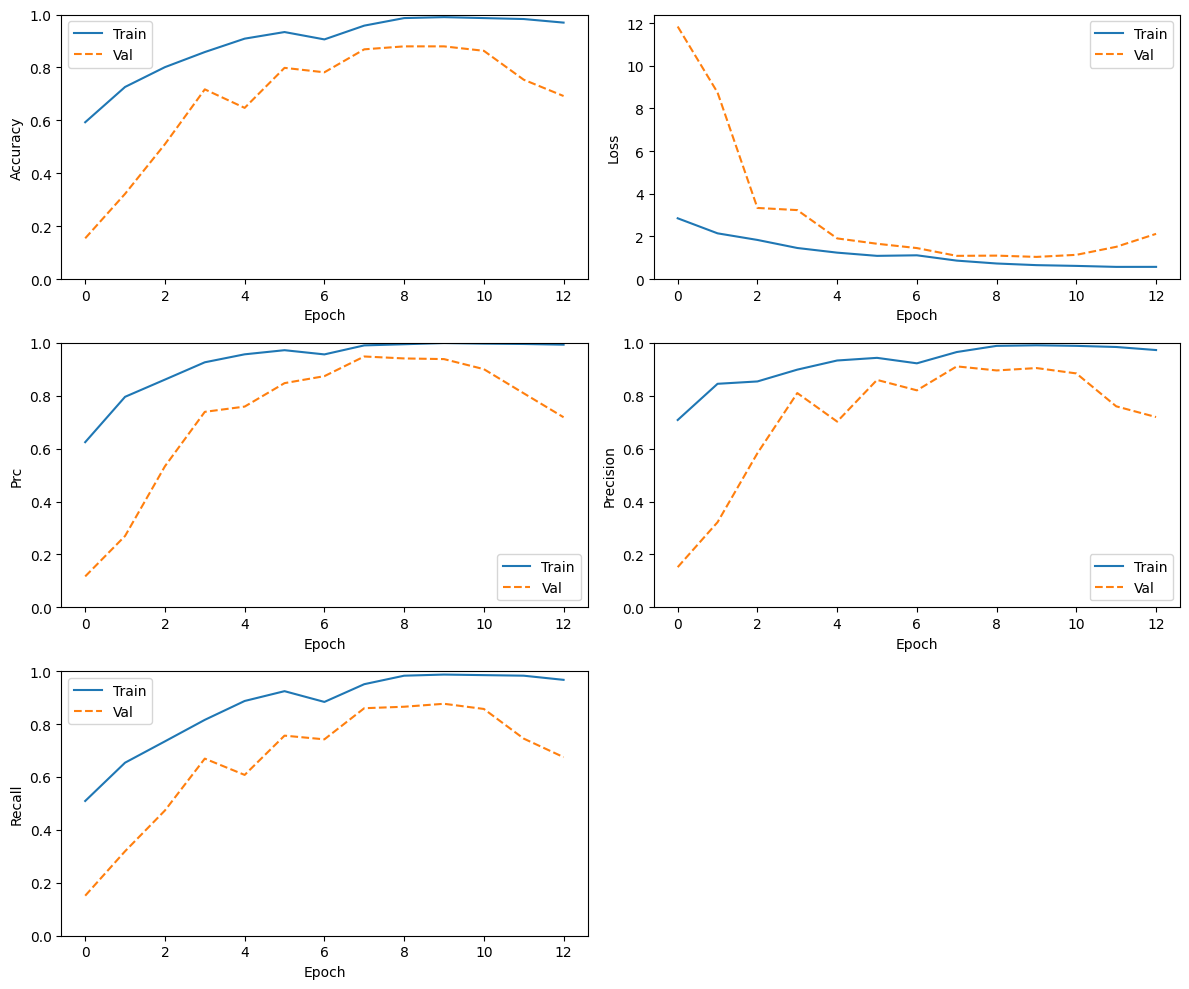

In [ ]:
plot_metrics(history)

In [ ]:
def read_class_labels(file_path):
    with open(file_path, "r") as file:
        class_labels = [line.strip() for line in file.readlines()]
    return class_labels

# Example usage
class_labels = read_class_labels("../input/classes/sample_classes.txt")
print(class_labels)

['auto-rickshaw', 'bicycle', 'bus', 'car', 'e-rickshaw', 'mini-bus', 'mini-truck', 'motorcycle', 'rickshaw', 'tractor', 'truck', 'van']


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8772 - auc: 0.9898 - loss: 1.0670 - prc: 0.9539 - precision: 0.9247 - recall: 0.8694
loss :  1.088040828704834
compile_metrics :  0.8683473467826843
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


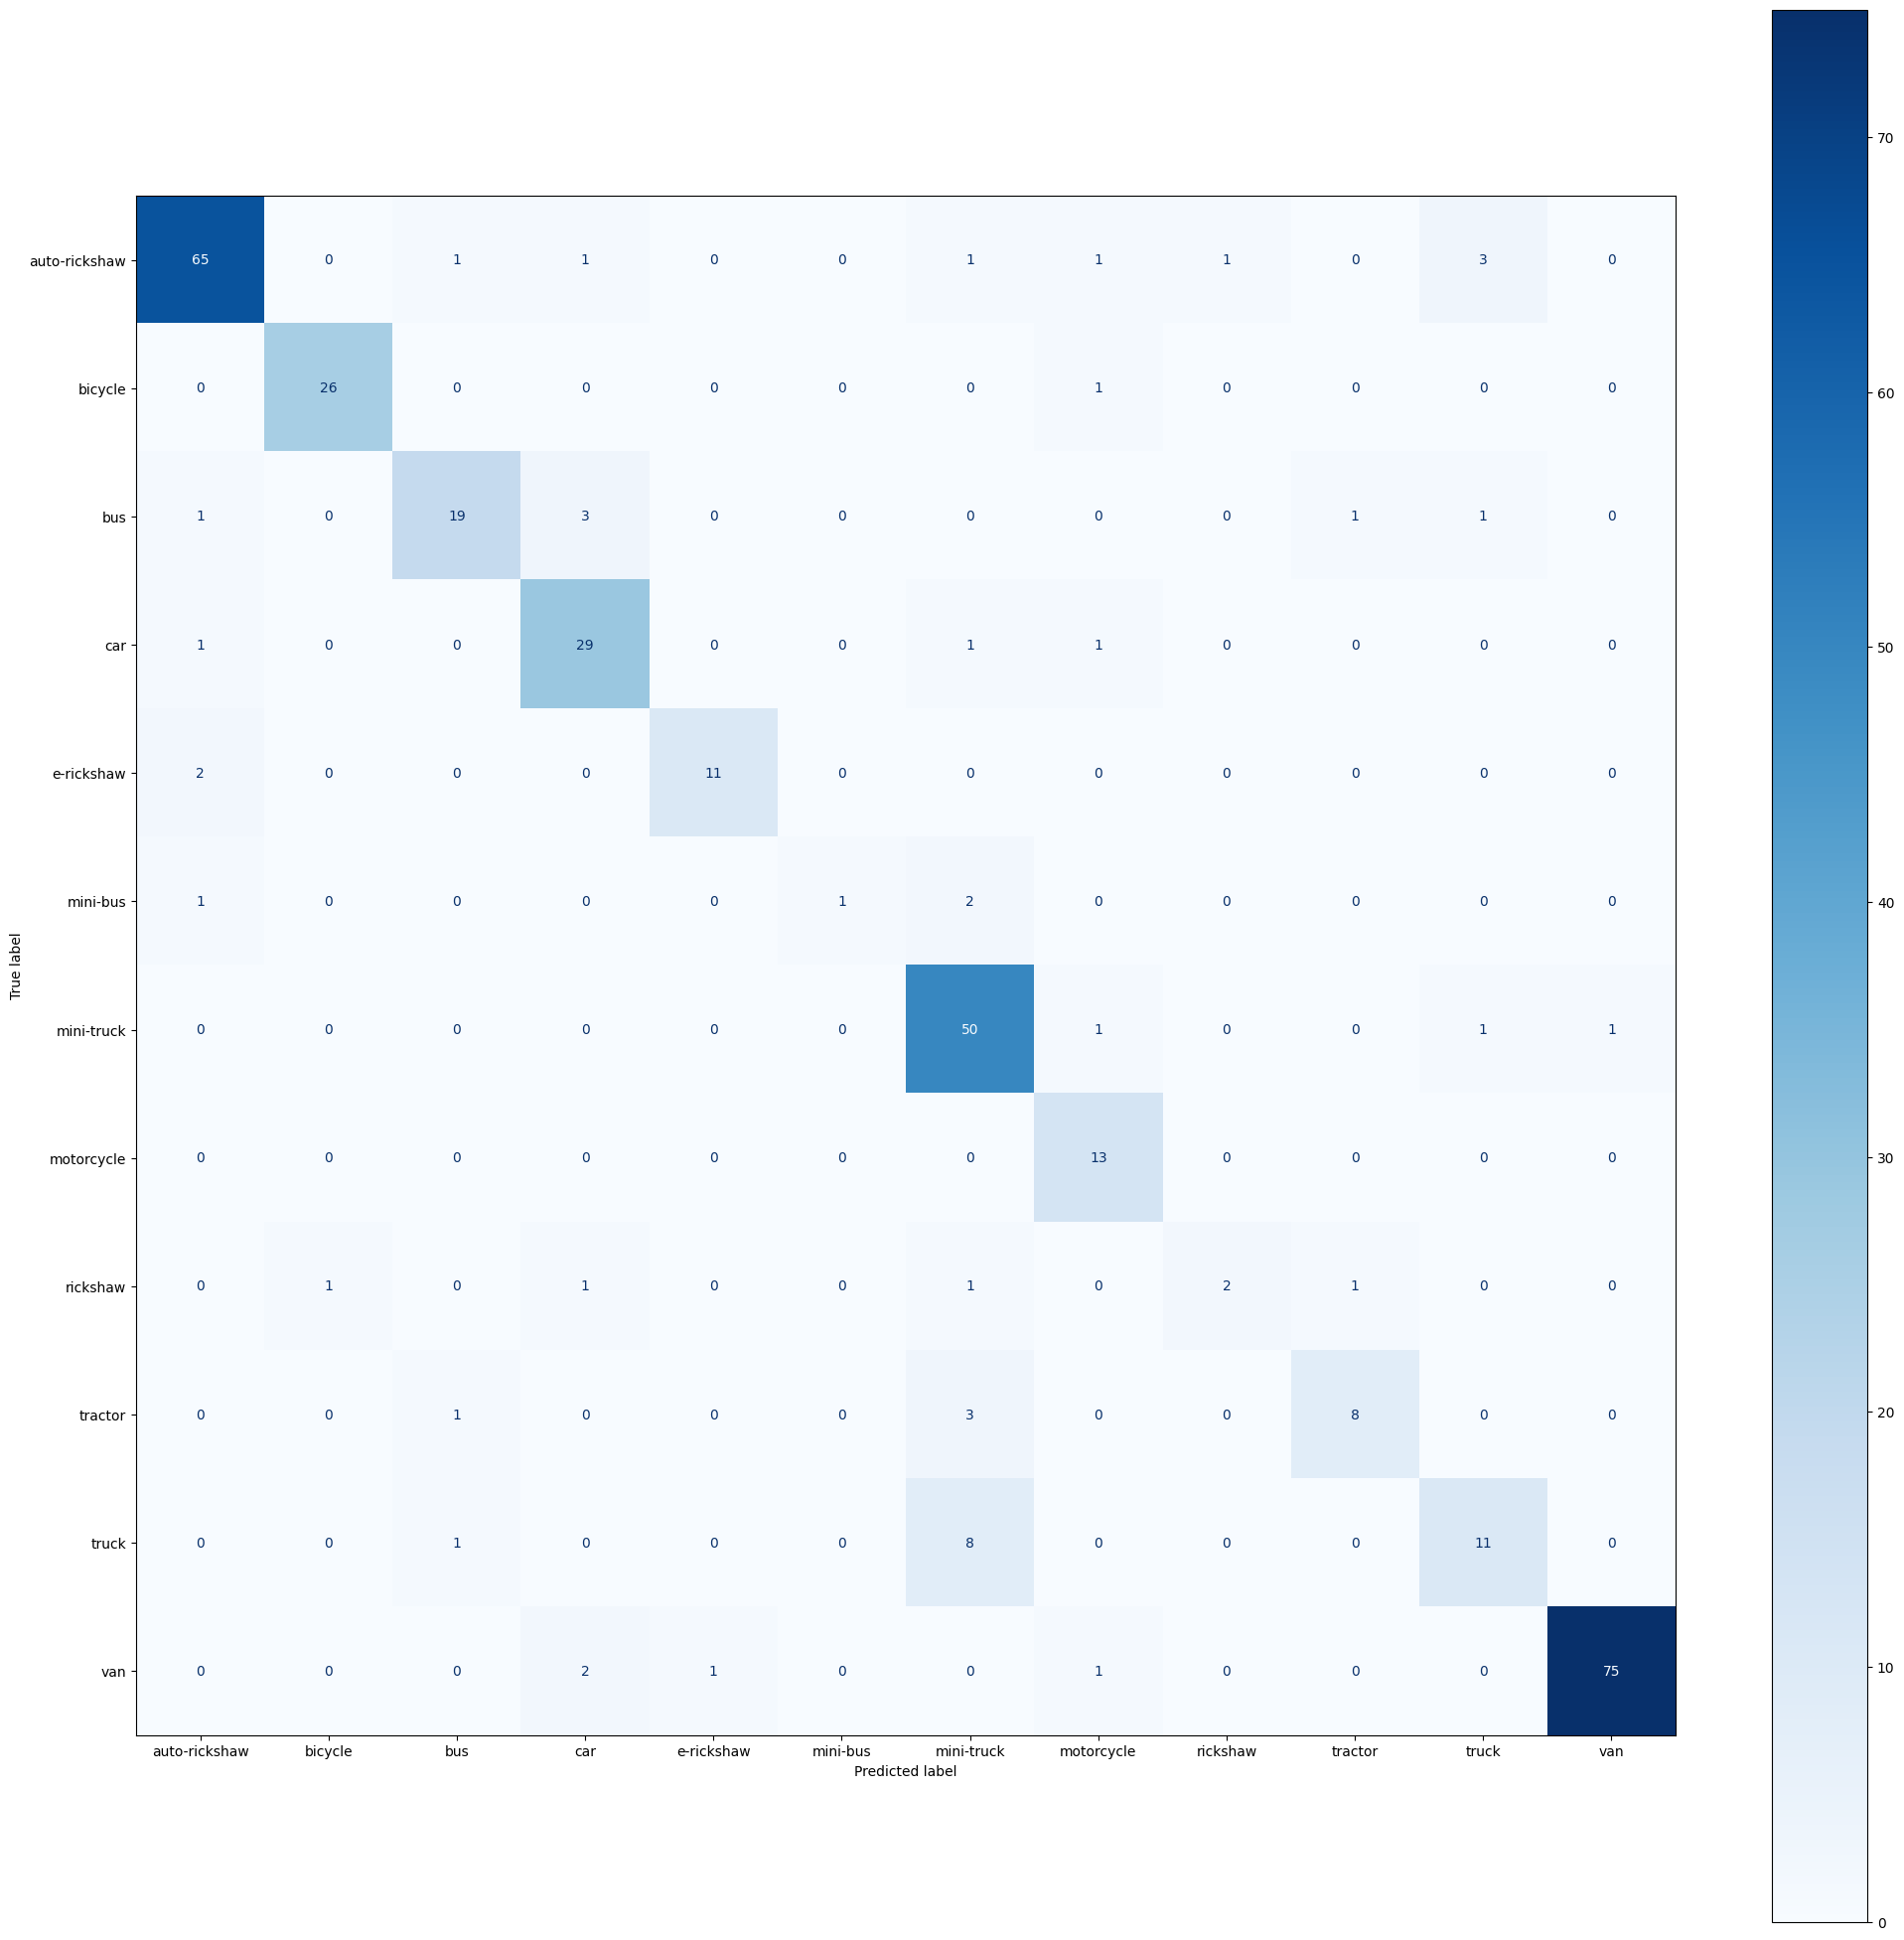

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Evaluate the model
results = model.evaluate(val_images, val_labels)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

# Get predictions
val_predictions = model.predict(x=val_images)

# Get the true labels and predicted labels
validation_index = tf.argmax(val_labels, axis=1).numpy()  # Convert to NumPy
predictions_index = tf.argmax(val_predictions, axis=1).numpy()  # Convert to NumPy

# Compute Confusion Matrix
cm = confusion_matrix(validation_index, predictions_index)

# Display Confusion Matrix
plt.rcParams['figure.figsize'] = [25, 25]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")  # Saves as a high-quality PNG
plt.show()

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Assuming `y_true` and `y_pred` are the true and predicted labels
report = classification_report(predictions_index, validation_index, target_names=class_labels)
print(report)

# If F1-score is computed separately
f1 = f1_score(predictions_index, validation_index, average='weighted')
print("Weighted F1-score:", f1)

> Model Saving

In [ ]:
model.save("model.keras")
model = tf.keras.models.load_model("model.keras")
model.export("saved_model")

> convert in onnx format

In [ ]:
import subprocess

subprocess.run(["python", "-m", "tf2onnx.convert", "--saved-model", "saved_model", "--output", "model.onnx"])

> validation of onnx model

In [ ]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "model.onnx"
session = ort.InferenceSession(onnx_model_path)

# Get input details
input_details = session.get_inputs()
input_name = input_details[0].name
input_shape = (1, 180, 180, 3)
input_dtype = np.float32

# Create a sample input
sample_input = np.random.rand(*input_shape).astype(input_dtype)

# Run inference
outputs = session.run(None, {input_name: sample_input})

# Print output shape
for idx, output in enumerate(outputs):
    print(f"Output {idx} shape: {output.shape}")